# Image segmentation with scivision

In this notebook, we use scivision to load several image segmentation models from [Hugging Face](https://huggingface.co/models?pipeline_tag=image-segmentation&sort=downloads) and run them on compatible datasource from the scivision catalog.

The hugging face models are loaded via the hugging face segmentation plugin for scivision, which is a model entry in the scivision catalog. Click the [link to the plugin repo](https://github.com/alan-turing-institute/scivision_huggingface_segmentation) to find out which models it can be used to load. 

In [1]:
from scivision import default_catalog, load_pretrained_model, load_dataset

In [2]:
# Get the model repo url
models_catalog = default_catalog.models.to_dataframe()
model_repo = models_catalog[models_catalog.name == "huggingface-segmentation"].url.item()
model_repo # Why not paste the repo link into your browser and see how it looks?

AnyUrl('https://github.com/alan-turing-institute/scivision_huggingface_segmentation', scheme='https', host='github.com', tld='com', host_type='domain', path='/alan-turing-institute/scivision_huggingface_segmentation')

In [3]:
facebook_model = load_pretrained_model(model_repo, model='facebook_detr_resnet_50_panoptic')
nvidia_model = load_pretrained_model(model_repo, model='nvidia_segformer_b5_finetuned_ade_640_640')
microsoft_model = load_pretrained_model(model_repo, model='microsoft_beit_large_finetuned_ade_640_640')

/opt/anaconda3/envs/scivision/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
compatible_datasources = default_catalog.compatible_datasources("huggingface-segmentation").to_dataframe()
compatible_datasources

,name,description,tasks,domains,url,format,labels_provided,institution,tags
0,data-000,None,"(TaskEnum.object_detection, TaskEnum.segmentat...","(optical-microscopy,)",https://github.com/stardist/stardist/releases/...,image,True,"(epfl,)","(help-needed, 3D, cell, cell-counting, biology..."
1,data-001,None,"(TaskEnum.segmentation, TaskEnum.thresholding,...","(multispectral, hyperspectral)",https://gitlab.au.dk/AUENG-Vision/OPPD/-/archi...,image,True,"(Aarhus University,)","(help-needed, 2D, plant-phenotyping, agricultu..."
3,data-003,Test images,"(TaskEnum.object_detection, TaskEnum.classific...","(computer-vision,)",https://github.com/alan-turing-institute/scivi...,image,True,"(Wikipedia by Erik Veland,)","(demo,)"
5,data-005,Sample dataset of satellite imagery required t...,"(TaskEnum.classificiation, TaskEnum.segmentation)","(computer-vision, earth-observation, ecology)",https://github.com/MartinSJRogers/VEdge_Detect...,image,False,"(Cambridge University,)","(2D, satellite, remote-sensing, ecology, envir..."


In [5]:
target_datasource = compatible_datasources.loc[compatible_datasources['name'] == 'data-003']
data_config = load_dataset(target_datasource.url.item())
print([i for i in data_config.keys()])

['test_image', 'airport', 'dog_cat']


In [9]:
dog_cat = data_config.dog_cat().to_dask() # The xarray.DataArray is one format accepted by the our models

/opt/anaconda3/envs/scivision/lib/python3.9/site-packages/xarray/core/dataset.py:2172: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  warnings.warn(


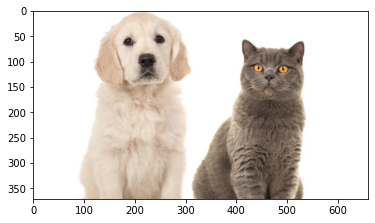

In [10]:
import matplotlib.pyplot as plt
plt.imshow(dog_cat)

In [12]:
fb_outputs = facebook_model.predict(dog_cat)
fb_outputs

DetrSegmentationOutput(loss=None, loss_dict=None, logits=tensor([[[-18.0036,   1.1826,  -4.6806,  ..., -18.1785, -17.2821,  13.2539],
         [-17.4801,  -0.8670,  -6.6026,  ..., -17.7647, -17.6639,  12.4569],
         [-18.0398,  -1.4888,  -6.5508,  ..., -17.5930, -17.1591,  12.4614],
         ...,
         [-17.2054,  -1.1052,  -3.4308,  ..., -16.6034, -16.1166,  12.9422],
         [-18.2399,   2.1947,  -4.4524,  ..., -18.2500, -17.6903,  12.9886],
         [-17.9907,   1.2483,  -4.2704,  ..., -18.0787, -17.8179,  13.0951]]],
       grad_fn=<AddBackward0>), pred_boxes=tensor([[[0.5027, 0.5005, 0.6335, 0.9737],
         [0.2518, 0.0125, 0.3768, 0.0255],
         [0.6824, 0.9791, 0.1955, 0.0386],
         [0.3803, 0.5012, 0.4905, 0.9747],
         [0.7181, 0.9370, 0.1460, 0.1177],
         [0.2625, 0.0103, 0.1519, 0.0208],
         [0.3818, 0.4993, 0.4879, 0.9770],
         [0.3169, 0.2029, 0.2270, 0.4030],
         [0.0382, 0.9283, 0.0759, 0.1400],
         [0.2831, 0.5232, 0.2479, 0

Experiment with visualising segmentation:

In [26]:
import tensorflow as tf

In [27]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [30]:
for pred_mask in fb_outputs.pred_masks:
    display(create_mask(pred_mask))

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.